# Введение

Архитектура современных GPU может быть условно разделена на три основных компонента: 
- DRAM (динамическая оперативная память) 
- SRAM (статическая оперативная память) 
- ALU (арифметико-логические устройства). 

Каждый из этих компонентов необходимо учитывать при оптимизации CUDA-кода:

1) Передачи данных из DRAM должны быть объединены в крупные транзакции, чтобы максимально использовать большую ширину шины современных интерфейсов памяти.
2) Данные должны вручную сохраняться в SRAM перед повторным использованием и управляться таким образом, чтобы минимизировать конфликты банков общей памяти при их извлечении.
3) Вычисления должны быть правильно распределены и запланированы как между потоковыми мультипроцессорами (SM), так и внутри них, чтобы обеспечить параллелизм на уровне инструкций и потоков, а также максимально использовать специализированные ALU (например, тензорные ядра).

**[Triton](https://github.com/triton-lang/triton)** — это мощный открытый фреймворк, упрощающий программирование для GPU, особенно в задачах, связанных с нейронными сетями. Aбстрагируя низкоуровневую сложность CUDA, Triton позволяет писать высокопроизводительный код для GPU с синтаксисом, похожим на Python, без необходимости глубокого знания CUDA.

- Высокая эффективность: Ядра Triton достигают производительности, сравнимой или превосходящей ручную оптимизацию на CUDA, например, умножение матриц в формате FP16 на уровне cuBLAS всего за 25 строк кода.
- Синтаксис, похожий на Python: Делает программирование для GPU доступным благодаря знакомым и простым конструкциям.

|               | **Описание**                                                                                                                                   | **CUDA** | **TRITON** |
|---------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------|----------|------------|
| **Оптимизация доступа к памяти (Memory Coalescing)**     | Обеспечивает группировку обращений к памяти потоками в меньшее количество более эффективных транзакций для оптимизации пропускной способности глобальной памяти. Требует явного указания выравнивания памяти и шаблонов доступа в коде. | Ручной   | Автоматический |
| **Управление общей памятью (Shared Memory Management)** | Ссылается на явное выделение и управление общедоступной памятью для ускорения частых обращений потоков внутри блока.                             | Ручной   | Автоматический |
| **Планирование вычислений внутри блока (Scheduling Within SMs)** | Управляет порядком выполнения потоков внутри одного потокового мультипроцессора (SM).                                                                 | Ручной   | Автоматический |
| **Планирование вычислений между блоками (Scheduling Across SMs)**     | Определяет, как рабочая нагрузка распределяется между несколькими потоковыми мультипроцессорами (SM) на GPU.                                           | Ручной   | Ручной         |



[Introducing Triton: Open-source GPU programming for neural networks July 28, 2021](https://openai.com/index/triton/)


# Базовый синтаксис

In [3]:
import torch
import triton
import triton.language as tl

@triton.jit
def add_kernel(
    x_ptr, 
    y_ptr,  
    output_ptr,  
    n_elements,  
    BLOCK_SIZE: tl.constexpr, 
):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y
    tl.store(output_ptr + offsets, output, mask=mask)


x = torch.tensor([1, 2, 3, 4, 4, 3, 2, 1, 0, 1], dtype=torch.float32, device='cuda')
y = torch.tensor([10, 20, 30, 40, 40, 30, 20, 10, 0, 10], dtype=torch.float32, device='cuda')

print("Input x:", x)
print("Input y:", y)

output = torch.empty_like(x)
n_elements = x.numel()  
grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']),)

add_kernel[grid](x_ptr=x, y_ptr=y, output_ptr=output, n_elements=n_elements, BLOCK_SIZE=4)

print("\nOutput:", output)

Input x: tensor([1., 2., 3., 4., 4., 3., 2., 1., 0., 1.], device='cuda:0')
Input y: tensor([10., 20., 30., 40., 40., 30., 20., 10.,  0., 10.], device='cuda:0')

Output: tensor([11., 22., 33., 44., 44., 33., 22., 11.,  0., 11.], device='cuda:0')


# Triton_viz

In [8]:
import torch
import triton
import triton.language as tl

import triton_viz

@triton.jit
def add_kernel(
    x_ptr, 
    y_ptr,  
    output_ptr,  
    n_elements,  
    BLOCK_SIZE: tl.constexpr, 
):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements
    print("\nPID NUMBER: ", pid)
    print("MASK: ", mask)
    print("offsets: ", offsets)
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    print("INPUT x: ", x)
    print("INPUT y: ",y)
    
    output = x + y
    print("OUTPUT: ",output)
    tl.store(output_ptr + offsets, output, mask=mask)

x = torch.tensor([1, 2, 3, 4, 4, 3, 2, 1, 0, 1], dtype=torch.float32, device='cuda')
y = torch.tensor([10, 20, 30, 40, 40, 30, 20, 10, 0, 10], dtype=torch.float32, device='cuda')

print(x)
print(y)
output = torch.empty_like(x)
n_elements = x.numel()  
grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']),)

triton_viz.trace(add_kernel)[grid](x_ptr=x, y_ptr=y, output_ptr=output, n_elements=n_elements, BLOCK_SIZE=4)
print()
print(output)  


triton_viz.launch()

tensor([1., 2., 3., 4., 4., 3., 2., 1., 0., 1.], device='cuda:0')
tensor([10., 20., 30., 40., 40., 30., 20., 10.,  0., 10.], device='cuda:0')

PID NUMBER:  [0]
MASK:  [ True  True  True  True]
offsets:  [0 1 2 3]
INPUT x:  [1. 2. 3. 4.]
INPUT y:  [10. 20. 30. 40.]
OUTPUT:  [11. 22. 33. 44.]

PID NUMBER:  [1]
MASK:  [ True  True  True  True]
offsets:  [4 5 6 7]
INPUT x:  [4. 3. 2. 1.]
INPUT y:  [40. 30. 20. 10.]
OUTPUT:  [44. 33. 22. 11.]

PID NUMBER:  [2]
MASK:  [ True  True False False]
offsets:  [ 8  9 10 11]
INPUT x:  [0. 1. 0. 0.]
INPUT y:  [ 0. 10.  0.  0.]
OUTPUT:  [ 0. 11.  0.  0.]

tensor([11., 22., 33., 44., 44., 33., 22., 11.,  0., 11.], device='cuda:0')
* Running on public URL: https://b89e8e95aa0a166e24.gradio.live


{}

# Type Promotion

**Приведение типов** происходит, когда тензоры с различными типами данных используются в одной операции. Для бинарных операций, связанных с магическими методами (dunder methods), и функции `tl.where` (по последним двум аргументам), Triton автоматически конвертирует входные тензоры в общий тип данных, следуя иерархии категорий:

1. `{bool}` < `{integral dypes}` < `{floating point dtypes}`

## Алгоритм приведения типов

1. **Категория**  
   Если один из тензоров имеет тип более высокого уровня, другой тензор будет приведен к этому типу.  
   **Пример:**  
   `(int32, bfloat16) -> bfloat16`

2. **Ширина**  
   Если оба тензора принадлежат одной категории типов, но имеют разную ширину, тензор с меньшей шириной будет приведен к типу с большей шириной.  
   **Пример:**  
   `(float32, float16) -> float32`

3. **Предпочтение float16**  
   Если оба тензора имеют одинаковую ширину и знаковость, но разные типы (например, `float16` и `bfloat16`), оба тензора будут приведены к `float16`.  
   **Пример:**  
   `(float16, bfloat16) -> float16`

4. **Предпочтение беззнаковых типов**  
   Если ширина и категория одинаковы, но знаковость различается, оба тензора будут приведены к беззнаковому типу.  
   **Пример:**  
   `(int32, uint32) -> uint32`

## Примеры

| Операция             | Приведение типов            |
|----------------------|-----------------------------|
| `(int32, bfloat16)`  | `bfloat16`                 |
| `(float32, float16)` | `float32`                  |
| `(float16, bfloat16)`| `float16`                  |
| `(int32, uint32)`    | `uint32`                   |


In [1]:
import triton
import triton.language as tl
import torch

@triton.jit
def type_promotion_kernel(x_ptr, y_ptr, z_ptr, BLOCK_SIZE: tl.constexpr):
    idx = tl.arange(0, BLOCK_SIZE)
    
    x = tl.load(x_ptr + idx)  
    y = tl.load(y_ptr + idx)  
    
    z = x + y
    
    tl.store(z_ptr + idx, z)


# Example 1: int32 + float32
x_int = torch.randint(0, 10, (8,), dtype=torch.int32, device='cuda')
y_float = torch.randn(8, dtype=torch.float32, device='cuda')
output = torch.empty(8, dtype=torch.float32, device='cuda')
type_promotion_kernel[(1,)](x_int, y_float, output, BLOCK_SIZE=8)
print("int32 + float32:")
print("\tInput x:", x_int.dtype)
print("\tInput y:", y_float.dtype)
print("\tOutput:", output.dtype)

# Example 2: float16 + float32
x_fp16 = torch.randn(8, dtype=torch.float16, device='cuda')
y_fp32 = torch.randn(8, dtype=torch.float32, device='cuda')
output = torch.empty(8, dtype=torch.float32, device='cuda')
type_promotion_kernel[(1,)](x_fp16, y_fp32, output, BLOCK_SIZE=8)
print("\nfloat16 + float32:")
print("\tInput x:", x_fp16.dtype)
print("\tInput y:", y_fp32.dtype)
print("\tOutput:", output.dtype)

# Example 3: float16 + bfloat16
x_fp16 = torch.randn(8, dtype=torch.float16, device='cuda')  
y_bf16 = torch.randn(8, dtype=torch.bfloat16, device='cuda')  
output = torch.empty(8, dtype=torch.float16, device='cuda')  
type_promotion_kernel[(1,)](x_fp16, y_bf16, output, BLOCK_SIZE=8)
print("\nfloat16 + bfloat16:")
print("\tInput x:", x_fp16.dtype)
print("\tInput y:", y_bf16.dtype)
print("\tOutput:", output.dtype)

# Example 4: int32 + uint32
x_int32 = torch.randint(0, 10, (8,), dtype=torch.int32, device='cuda')
y_uint32 = torch.randint(0, 10, (8,), dtype=torch.uint32, device='cuda')
output = torch.empty(8, dtype=torch.uint32, device='cuda')
type_promotion_kernel[(1,)](x_int32, y_uint32, output, BLOCK_SIZE=8)
print("\nint32 + uint32:")
print("\tInput x:", x_int32.dtype)
print("\tInput y:", y_uint32.dtype)
print("\tOutput:", output.dtype)


int32 + float32:
	Input x: torch.int32
	Input y: torch.float32
	Output: torch.float32

float16 + float32:
	Input x: torch.float16
	Input y: torch.float32
	Output: torch.float32

float16 + bfloat16:
	Input x: torch.float16
	Input y: torch.bfloat16
	Output: torch.float16

int32 + uint32:
	Input x: torch.int32
	Input y: torch.uint32
	Output: torch.uint32


# Broadcasting в тензорных операциях

**Broadcasting** в `triton` в большинстве аналогичен `numpy`. Позволяет выполнять операции над тензорами с различными формами, автоматически расширяя их до совместимых размеров без копирования данных. Это упрощает вычисления и позволяет избежать явного изменения форм тензоров.



In [2]:
import triton
import triton.language as tl
import torch

@triton.jit
def broadcast_kernel(x_ptr, y_ptr, z_ptr, BLOCK_SIZE: tl.constexpr):
    idx = tl.arange(0, BLOCK_SIZE)  
    x = tl.load(x_ptr + idx)  
    y = tl.load(y_ptr)  
    z = x + y 
    tl.store(z_ptr + idx, z)  

x = torch.arange(8, dtype=torch.float32, device='cuda') 
y = torch.tensor(10, dtype=torch.float32, device='cuda') 
output = torch.empty_like(x)
broadcast_kernel[(1,)](x, y, output, BLOCK_SIZE=8)
print("\nBroadcasting со скаляром:")
print("x:", x)
print("y (scalar):", y)
print("Output: ", output)



Broadcasting со скаляром:
x: tensor([0., 1., 2., 3., 4., 5., 6., 7.], device='cuda:0')
y (scalar): tensor(10., device='cuda:0')
Output:  tensor([10., 11., 12., 13., 14., 15., 16., 17.], device='cuda:0')


In [3]:
import triton
import triton.language as tl
import torch

@triton.jit
def multi_dim_broadcast_example(x_ptr, y_ptr, res_ptr, n: tl.constexpr, m: tl.constexpr):
    row = tl.arange(0, m)  
    col = tl.arange(0, n)  

    x = tl.load(x_ptr + col)  # (1, 8)
    y = tl.load(y_ptr + row)[:, None]  # (1, 4) -> (4, 1)

    # Broadcasting: x -> (4, 8), y -> (4, 8)
    result = x + y

    tl.store(res_ptr + row[:, None] * n + col[None, :], result)

m, n = 4, 8

x_tensor = torch.tensor([[1, 2, 3, 4, 5, 6, 7, 8]], dtype=torch.float32).cuda()  # (1, 8)
y_tensor = torch.tensor([[10, 20, 30, 40]], dtype=torch.float32).cuda()  # (1, 4)
res_tensor = torch.empty((4, 8), dtype=torch.float32).cuda()  # (4, 8)

multi_dim_broadcast_example[(1,)](
    x_tensor, y_tensor, res_tensor, n, m
)

print(f"Input x:\n{x_tensor}")
print("Input x shape:", x_tensor.shape)
print()
print(f"Input y:\n{y_tensor}")
print("Input y shape:", y_tensor.shape)
print()
print(f"Result (x + y):\n{res_tensor}")
print("Result (x + y) shape:", res_tensor.shape)

Input x:
tensor([[1., 2., 3., 4., 5., 6., 7., 8.]], device='cuda:0')
Input x shape: torch.Size([1, 8])

Input y:
tensor([[10., 20., 30., 40.]], device='cuda:0')
Input y shape: torch.Size([1, 4])

Result (x + y):
tensor([[11., 12., 13., 14., 15., 16., 17., 18.],
        [21., 22., 23., 24., 25., 26., 27., 28.],
        [31., 32., 33., 34., 35., 36., 37., 38.],
        [41., 42., 43., 44., 45., 46., 47., 48.]], device='cuda:0')
Result (x + y) shape: torch.Size([4, 8])


# Различия с NumPy: Округление при целочисленном делении в Triton

В **Triton** операторы целочисленного деления и остатка от деления следуют семантике языка C, а не Python, для повышения эффективности. Это ведет к некоторым отличиям в поведении операций, особенно при работе с числами разных знаков.

---

## Округление при целочисленном делении

### Семантика C:
- В **C** целочисленное деление (`//`) выполняется с округлением в сторону нуля, то есть результат всегда будет приближен к нулю, независимо от знаков делимого и делителя.
  
  **Пример**:
  - `7 // 3 = 2`  
  - `-7 // 3 = -2`
  
  Округление происходит к меньшему по абсолютной величине числу, то есть результат никогда не будет округляться в сторону минус бесконечности.

### Семантика Python:
- В **Python** целочисленное деление работает по принципу округления к минус бесконечности для отрицательных чисел.
  
  **Пример**:
  - `7 // 3 = 2`  
  - `-7 // 3 = -3`

---

## Модульная операция (%)

Оператор остатка от деления в **Triton** и **C** также ведет себя по-другому, чем в **Python**.
  
```plaintext
  a % b = a - b * (a // b)
```

- **Triton**
```plaintext
  -7 % 3 = -7 - 3*(-7//3) = -7 - 3*(-2) = -1
```

- **Python**
```plaintext
  -7 % 3 = -7 - 3*(-7//3) = -7 - 3*(-3) = 2
```

In [4]:
import triton
import triton.language as tl
import torch

@triton.jit
def triton_kernel(a_ptr, b_ptr, div_ptr, mod_ptr, BLOCK_SIZE: tl.constexpr):
    idx = tl.arange(0, BLOCK_SIZE)
    a = tl.load(a_ptr + idx)
    b = tl.load(b_ptr + idx)
    
    div_result = a // b
    mod_result = a % b
    
    tl.store(div_ptr + idx, div_result)
    tl.store(mod_ptr + idx, mod_result)

a = torch.tensor([-7], dtype=torch.int32, device='cuda')
b = torch.tensor([3], dtype=torch.int32, device='cuda')

div_result = torch.empty(1, dtype=torch.int32, device='cuda')
mod_result = torch.empty(1, dtype=torch.int32, device='cuda')

triton_kernel[(1,)](a, b, div_result, mod_result, BLOCK_SIZE=1)

print("Triton:")
print(f"\ta // b = {a[0]} // {b[0]} =  {div_result[0]}")  # Ожидаемый результат: -2
print(f"\ta % b = {a[0]} % {b[0]} =  {mod_result[0]}")   # Ожидаемый результат: -1


a = -7
b = 3

result_div = a // b

result_mod = a % b

print("\nPython:")
print(f"\ta // b = {a} // {b} = {result_div}")  # Ожидаемый результат: -3
print(f"\ta % b = {a} % {b} =  {result_mod}")    # Ожидаемый результат: 2

Triton:
	a // b = -7 // 3 =  -2
	a % b = -7 % 3 =  -1

Python:
	a // b = -7 // 3 = -3
	a % b = -7 % 3 =  2


---

### x // 3 + y % 2

In [5]:
import torch
import triton
import triton.language as tl

@triton.jit
def add_kernel(
    x_ptr,
    y_ptr,
    output_ptr,
    n_elements,
    BLOCK_SIZE: tl.constexpr,
):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x // 3 + y % 2
    tl.store(output_ptr + offsets, output, mask=mask)

def add(x: torch.Tensor, y: torch.Tensor):
    assert x.is_cuda and y.is_cuda
    output = torch.empty_like(x)
    n_elements = x.numel()
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']),)
    add_kernel[grid](x, y, output, n_elements, BLOCK_SIZE=32)
    return output


x = torch.tensor([-9, -6, -5, -4], dtype=torch.int32, device='cuda')
y = torch.tensor([1, -2, -3, 4], dtype=torch.int32, device='cuda')
output = add(x, y)

- Что выведет программа?

- Сколько значений может принять `pid`?

- Как выглядит маска (`mask`) массив?

In [6]:
print(output)

tensor([-2, -2, -2, -1], device='cuda:0', dtype=torch.int32)


### answers check


`a % b = a - b * (a // b)`

In [7]:
def c_style_div(x, y):
    """Имитация поведения целочисленного деления в C."""
    return int(x / y)  

def c_style_mod(x, y):
    """Имитация поведения взятия остатка в C."""
    return x - c_style_div(x, y) * y

x = [-9, -6, -5, -4]
y = [1, -2, -3, 4]

for i in range(len(x)):
    print(f"{x[i]:2n} // 3 + {y[i]:2n} % 2 = {c_style_div(x[i], 3):2n} + ({y[i]:2n} - 2*({y[i]:2n} // 2)) = {c_style_div(x[i], 3):2n} + ({y[i]:2n} - 2*({c_style_div(y[i], 2):2n})) = {c_style_div(x[i], 3):2n} + {c_style_mod(y[i],2):2n} = {c_style_div(x[i], 3) + c_style_mod(y[i], 2)}")


-9 // 3 +  1 % 2 = -3 + ( 1 - 2*( 1 // 2)) = -3 + ( 1 - 2*( 0)) = -3 +  1 = -2
-6 // 3 + -2 % 2 = -2 + (-2 - 2*(-2 // 2)) = -2 + (-2 - 2*(-1)) = -2 +  0 = -2
-5 // 3 + -3 % 2 = -1 + (-3 - 2*(-3 // 2)) = -1 + (-3 - 2*(-1)) = -1 + -1 = -2
-4 // 3 +  4 % 2 = -1 + ( 4 - 2*( 4 // 2)) = -1 + ( 4 - 2*( 2)) = -1 +  0 = -1


# Triton типы данных

In [8]:
import torch
import triton
import triton.language as tl

import triton_viz

from tabulate import tabulate


@triton.jit
def add_kernel(
    x_ptr, 
    y_ptr,  
    output_ptr,  
    n_elements,  
    BLOCK_SIZE: tl.constexpr, 
):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
    mask = offsets < n_elements

    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    
    output = x + y
    tl.store(output_ptr + offsets, output, mask=mask)
    
    data = [
        ["x_ptr", x_ptr.dtype, type(x_ptr)],
        ["y_ptr", y_ptr.dtype, type(y_ptr)],
        ["output_ptr", output_ptr.dtype, type(output_ptr)],
        [],
        ["BLOCK_SIZE", "N/A", type(BLOCK_SIZE)],
        [],
        ["n_elements", n_elements.dtype, type(n_elements)],
        ["pid", pid.dtype, type(pid)],
        ["block_start", block_start.dtype, type(block_start)],
        ["offsets", offsets.dtype, type(offsets)],
        [],
        ["mask", mask.dtype, type(mask)],
        [],
        ["x", x.dtype, type(x)],
        ["output", output.dtype, type(output)],
        [],
        ["output_ptr + offsets", (output_ptr + offsets).dtype, type(output_ptr + offsets)]
    ]

    headers = ["Объект", "dtype", "type"]

    print(tabulate(data, headers=headers, tablefmt="pretty"))


x = torch.tensor([1, 2, 3, 4, 4, 3, 2, 1, 0, 1], dtype=torch.float32, device='cuda')
y = torch.tensor([10, 20, 30, 40, 40, 30, 20, 10, 0, 10], dtype=torch.float32, device='cuda')

output = torch.empty_like(x)
n_elements = x.numel()  
grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']),)

triton_viz.trace(add_kernel)[grid](x_ptr=x, y_ptr=y, output_ptr=output, n_elements=n_elements, BLOCK_SIZE=16)



/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


+----------------------+---------------+---------------------------------------+
|        Объект        |     dtype     |                 type                  |
+----------------------+---------------+---------------------------------------+
|        x_ptr         | pointer<fp32> | <class 'triton.language.core.tensor'> |
|        y_ptr         | pointer<fp32> | <class 'triton.language.core.tensor'> |
|      output_ptr      | pointer<fp32> | <class 'triton.language.core.tensor'> |
|                      |               |                                       |
|      BLOCK_SIZE      |      N/A      |             <class 'int'>             |
|                      |               |                                       |
|      n_elements      |     int32     | <class 'triton.language.core.tensor'> |
|         pid          |     int32     | <class 'triton.language.core.tensor'> |
|     block_start      |     int32     | <class 'triton.language.core.tensor'> |
|       offsets        |    

# Память и арифметика указателей в C

В языке программирования C переменные могут быть представлены через указатели, которые хранят адреса памяти. Указатель представляет собой переменную, которая содержит адрес другой переменной, а не её значение.

### Размер указателя

Размер указателя зависит от типа данных, на который он указывает. Например, указатель на тип `int32` имеет размер 4 байта, так как `int32` занимает 4 байта в памяти. Когда мы работаем с указателями, важно понимать, что арифметика указателей автоматически учитывает размер типа данных.

### Пример арифметики указателей

Рассмотрим пример программы:

```c
#include <stdio.h>
int main(void)
{
    int n = 10;
    int *ptr = &n;
    printf("address=%p \t value=%d \n", (void*)ptr, *ptr); //address=0060FEAB value=10
    ptr++;  // Увеличиваем указатель на 1
    printf("address=%p \t value=%d \n", (void*)ptr, *ptr); //address=0060FEAC value=6356652
    ptr--;  // Уменьшаем указатель на 1
    printf("address=%p \t value=%d \n", (void*)ptr, *ptr); //address=0060FEAB value=10
    return 0;
}
```

P.S. При помощи оператора `*` можно получить значение, на которое указывает указатель, а с помощью оператора `&` можно получить адрес переменной. Например, `*ptr` даст значение переменной `n` (т.к. `int *ptr = &n;` ).

### Массивы и арифметика указателей

Массив в `C` представляет собой непрерывный блок памяти, в котором хранятся его элементы. Размер массива определяется выражением `n * sizeof(data_type)`, где `n` — количество элементов в массиве, а `data_type` — тип элементов массива. 
При этом массив в C фактически является указателем на первый элемент массива (требуется вместо всех данных хранить ссылку только на первый элемент). Это означает, что можно использовать арифметику указателей для доступа к элементам массива. 


```c
#include <stdio.h>

int main(void)
{
    int numbers[] = {11, 12, 13, 14}; 
    for(size_t i = 0; i < sizeof(numbers) / sizeof(numbers[0]); ++i) {
        printf("numbers[%d]: %p; value: %d\n", i, numbers + i, *(numbers + i));
    }
    return 0;
}
```

```plaintext
    numbers[0]: 0x7fffb4d10140; value: 11
    numbers[1]: 0x7fffb4d10144; value: 12
    numbers[2]: 0x7fffb4d10148; value: 13
    numbers[3]: 0x7fffb4d1014c; value: 14
```

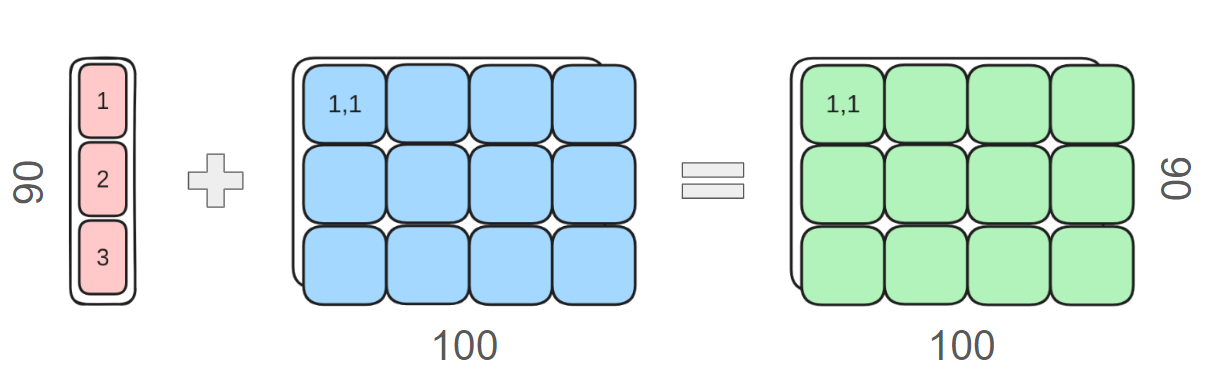

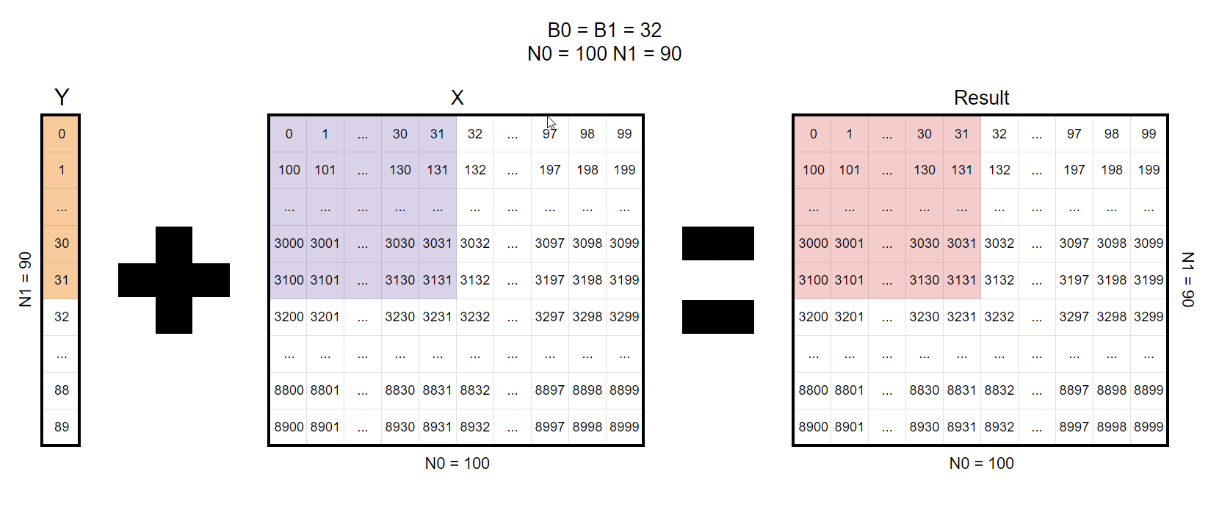

In [9]:
import torch
import triton
import triton.language as tl

import triton_viz

@triton.jit
def mul_relu_block_back_kernel(x_ptr, y_ptr, dz_ptr, N0, N1, B0: tl.constexpr, B1: tl.constexpr):
    pid_0 = tl.program_id(0)
    pid_1 = tl.program_id(1)

    off_x = tl.arange(0, B0) + pid_0 * B0
    off_y = tl.arange(0, B1) + pid_1 * B1
    off = off_x[None, :] + off_y[:, None] * N0

    mask_x = off_x < N0 # 100
    mask_y = off_y < N1 # 90
    mask = mask_x[None, :] & mask_y[:, None]
    y = tl.load(y_ptr + off_y, mask_y, 0)
    x = tl.load(x_ptr + off, mask, 0)

    output = x + y[:, None] 

    tl.store(dz_ptr + off, output, mask)

B = {'B0': 32, 'B1': 32}
nelem = {'N0': 100, 'N1': 90}

arrays = [
    torch.randint(-10,10, [90, 100]),
    torch.randint(-10,10, [90]),
    torch.randint(-10,10, [90, 100]),
]

grid = lambda meta: (triton.cdiv(nelem["N0"], meta["B0"]),
                         triton.cdiv(nelem.get("N1", 1), meta.get("B1", 1)))

triton_viz.trace(mul_relu_block_back_kernel)[grid](*arrays, **B, **nelem)
triton_viz.launch()

print("Input X:\n",arrays[0])
print()
print("Input Y:\n",arrays[1])
print()
print("Output:\n",arrays[2])

* Running on public URL: https://829a3bdca875fb62d3.gradio.live


Input X:
 tensor([[ 6,  8, -5,  ...,  1,  3,  5],
        [ 6,  2, -7,  ...,  7, -9,  8],
        [ 8,  1, -3,  ...,  6, -8, -8],
        ...,
        [-8, -1,  1,  ...,  1, -8,  8],
        [ 5,  6, -4,  ..., -1, -8,  7],
        [-6, -9, -2,  ...,  8,  9,  5]])

Input Y:
 tensor([ -3,   5,  -3,   5,  -5,   9, -10,  -3,   3,   4,   1,   9,   1,   9,
          6,   1,  -4,   9,  -4,  -3,  -9,  -3,   9,  -3,   6,   1, -10,   4,
         -1,  -8,  -7,   1,   1,   5,  -4,  -8,  -3,  -7,  -9,  -7,   9,   3,
          1,   9,  -5,   7,  -8,  -9,  -2,   3,  -4,   8,  -8,  -9,  -1,  -2,
          3,   8,  -8,  -7,   0,   4,   0,  -6,  -6,  -7,  -1,  -2,   8,   3,
         -9,   3,   8,  -8, -10,   8,  -9,   6,  -1,  -4,  -6,  -4,   4,   9,
         -8,   3,   7,  -2,   9,   7])

Output:
 tensor([[  3,   5,  -8,  ...,  -2,   0,   2],
        [ 11,   7,  -2,  ...,  12,  -4,  13],
        [  5,  -2,  -6,  ...,   3, -11, -11],
        ...,
        [-10,  -3,  -1,  ...,  -1, -10,   6],
        [ 1

**Пример: Как поменять соседние элементы массива при помощи арифметики указателей**

---

[10, 11, 12, 13, 14, 15] -> [ 11, 10, 13, 12, 15, 14]

---

range = [0, 1, 2, 3, 4, 5]

Necessary_range = [1, 0, 3, 2, 5, 4]

---

[0, 1, 2, 3, 4, 5]

[1, 0, 3, 2, 5, 4]

**[1, -1, 1, -1, 1, -1]**

---
**value % 2**

Odd_range:  [1, 0, 1, 0, 1, 0]

Even_range:  [0, 1, 0, 1, 0, 1]

**Odd_range - Even_range = [1, -1, 1, -1, 1, -1]**

---

Range_swaped:  [1, 0, 3, 2, 5, 4]

In [10]:
import torch
import triton
import triton.language as tl
import triton_viz


@triton.jit
def swap_every_second_element(x_ptr, res_ptr, N0, BLOCK_SIZE: tl.constexpr):
    pid = tl.program_id(0)
    range = tl.arange(0, BLOCK_SIZE) + pid*BLOCK_SIZE
    mask = range < N0
    
    print("\nRange: ", range)
    range_even = range % 2 
    
    range_odd = (range+1) % 2

    print("Odd: ", range_odd)
    print("Even: ", range_even)

    necessary_range = range_odd - range_even

    print("Necessary_range: ", necessary_range)

    range_swaped = range + necessary_range

    print("Range_swaped: ", range_swaped)
    

    x = tl.load(x_ptr + range_swaped, mask)

    tl.store(res_ptr + range, x, mask)

x_tensor = torch.tensor([10, 11, 12, 13, 14, 15], dtype=torch.int32).cuda()
n_elements = x_tensor.numel()
BLOCK_SIZE = 4
res_tensor = torch.zeros_like(x_tensor).cuda()

grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']),)

triton_viz.trace(swap_every_second_element)[grid](x_tensor, res_tensor, n_elements, BLOCK_SIZE)


print("\nInput:", x_tensor)
print("Output:", res_tensor)

triton_viz.launch()



Range:  [0 1 2 3]
Odd:  [1 0 1 0]
Even:  [0 1 0 1]
Necessary_range:  [ 1 -1  1 -1]
Range_swaped:  [1 0 3 2]

Range:  [4 5 6 7]
Odd:  [1 0 1 0]
Even:  [0 1 0 1]
Necessary_range:  [ 1 -1  1 -1]
Range_swaped:  [5 4 7 6]

Input: tensor([10, 11, 12, 13, 14, 15], device='cuda:0', dtype=torch.int32)
Output: tensor([11, 10, 13, 12, 15, 14], device='cuda:0', dtype=torch.int32)
* Running on public URL: https://5d6ebf1d2c320d3766.gradio.live


{}

**Пример перемножения матриц поблочно:**

In [11]:
import torch
import triton
import triton.language as tl
import triton_viz

@triton.jit
def dot_kernel(x_ptr, y_ptr, z_ptr, N0, N1, MID, B0: tl.constexpr, B1: tl.constexpr, B_MID: tl.constexpr):
    pid_0 = tl.program_id(0)
    pid_1 = tl.program_id(1)

    outs = tl.full((B0, B1), 0.0, dtype=tl.float32)

    pid_0_off = (tl.arange(0, B0) + pid_0 * B0) * N1
    pid_1_off = tl.arange(0, B1) + pid_1 * B1
    off = pid_0_off[:, None] + pid_1_off[None, :]
    
    out_mask = ((tl.arange(0, B0) + pid_0 * B0) < N0)[:, None] & \
               (tl.arange(0, B1) + pid_1 * B1) < N1
    
    for k in range(0, MID, B_MID):
        off_x_d0 = (tl.arange(0, B0) + pid_0 * B0) * MID
        off_x_d1 = (tl.arange(0, B_MID) + k)
        off_x = off_x_d0[:, None] + off_x_d1[None, :]
        mask_x = (off_x_d1 < MID)[None, :] & ((tl.arange(0, B0) + pid_0 * B0) < N0)[:, None]

        off_y_d0 = tl.arange(0, B1) + pid_1 * B1
        off_y_d1 = (tl.arange(0, B_MID) + k) * N1
        off_y = off_y_d1[:, None] + off_y_d0[None, :]
        mask_y = ((tl.arange(0, B_MID) + k) < MID)[:, None] & (off_y_d0 < N1)

        x = tl.load(x_ptr + off_x, mask_x, 0)
        y = tl.load(y_ptr + off_y, mask_y, 0)
            
        outs += tl.dot(x, y)
    
    tl.store(z_ptr + off, outs, out_mask)

B = {"B0": 16, "B1": 16, "B_MID": 16}

nelem = {"N0": 64, "N1": 32, "MID": 32}

arrays = [
    torch.randint(-10, 10, [nelem["N0"], nelem["MID"]]).to(torch.float32).cuda(),
    torch.randint(-10, 10, [nelem["MID"], nelem["N1"]]).to(torch.float32).cuda(),
    torch.randint(-10, 10, [nelem["N0"], nelem["N1"]]).to(torch.float32).cuda(),
]

grid = lambda meta: (triton.cdiv(nelem["N0"], meta["B0"]),
                     triton.cdiv(nelem["N1"], meta["B1"]))

triton_viz.trace(dot_kernel)[grid](*arrays, **B, **nelem)

triton_viz.launch()

print("Input X:\n", arrays[0])
print("\nInput Y:\n", arrays[1])
print("\nOutput:\n", arrays[2])
print("\nMAX DIFFERENCE: ", torch.max(torch.abs(torch.matmul(arrays[0], arrays[1]) - arrays[2])).item())


* Running on public URL: https://23272421263e8ccaf0.gradio.live


Input X:
 tensor([[ -2.,  -4.,   1.,  ...,   3.,  -4.,  -5.],
        [ -1.,   8.,   3.,  ...,  -1.,   2.,   6.],
        [  9.,   9.,   7.,  ...,   0.,   2.,  -5.],
        ...,
        [ -4.,  -4., -10.,  ...,   5.,  -5.,   0.],
        [  7.,   0.,  -2.,  ...,  -9.,  -9.,   8.],
        [  1.,  -7.,  -4.,  ...,  -3.,   0.,   7.]], device='cuda:0')

Input Y:
 tensor([[  6.,   3.,   5.,  ...,  -1.,   7.,   2.],
        [  3.,   8.,  -5.,  ...,  -3.,   5., -10.],
        [  0.,  -9.,   3.,  ...,  -5.,  -7.,  -7.],
        ...,
        [  9.,   4.,  -5.,  ...,   6.,  -9.,  -6.],
        [-10.,   2.,  -7.,  ...,   9.,  -1.,   3.],
        [  7.,   4.,   0.,  ...,   9.,   8.,   3.]], device='cuda:0')

Output:
 tensor([[ 100.,   80.,  -80.,  ...,   29.,    8.,  194.],
        [ 248.,    1.,  -99.,  ..., -126.,  158.,  -29.],
        [  56.,  -42.,  -52.,  ...,   27.,  -75., -155.],
        ...,
        [ 278.,  570., -293.,  ..., -137.,  450., -202.],
        [ 191.,   39.,  222.,  ...,   

# Atomic Operations

In [3]:
import torch
import triton
import triton.language as tl

@triton.jit
def demo(x_ptr):
    range = tl.arange(0, 8)
    mask = range < 5
    x = tl.load(x_ptr + range, mask, 0)
    y = tl.load(x_ptr + range, mask, 0)
    res = x + y
    tl.store(x_ptr + range, res, mask)

input_arr = torch.ones(8, dtype=torch.float32).cuda()

print("Input: ", input_arr)

demo[(10,)](input_arr)

print("Output: ", input_arr)

Input:  tensor([1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
Output:  tensor([2., 2., 2., 2., 2., 1., 1., 1.], device='cuda:0')


- Где ошибка в этом примере?

## Atomic Operations in Triton

---

- `atomic_add`
Выполняет атомарное сложение по адресу, указанному в `pointer`.

---

- `atomic_and`
Выполняет атомарную логическую операцию И по адресу, указанному в `pointer`.

---

- `atomic_cas`
Выполняет атомарную операцию сравнения и обмена (compare-and-swap) по адресу, указанному в `pointer`.

---

- `atomic_max`
Выполняет атомарное вычисление максимума по адресу, указанному в `pointer`.

---

- `atomic_min`
Выполняет атомарное вычисление минимума по адресу, указанному в `pointer`.

---

- `atomic_or`
Выполняет атомарную логическую операцию ИЛИ по адресу, указанному в `pointer`.

---

- `atomic_xchg`
Выполняет атомарную операцию обмена по адресу, указанному в `pointer`.

---

- `atomic_xor`
Выполняет атомарную логическую операцию исключающее ИЛИ (XOR) по адресу, указанному в `pointer`.

---


In [1]:
import torch
import triton
import triton.language as tl

@triton.jit
def atomic_demo(x_ptr):
    range = tl.arange(0, 8)
    mask = range < 5
    x = tl.load(x_ptr + range, mask, 0)
    res = x + 1
    tl.atomic_add(x_ptr + range, res, mask)  

input_arr = torch.ones(8, dtype=torch.float32).cuda()

print("Input: ", input_arr)

atomic_demo[(2,)](input_arr)

print("Output:", input_arr)


Input:  tensor([1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0')
Output: tensor([5., 5., 5., 5., 5., 1., 1., 1.], device='cuda:0')


---

Input 

**x_ptr = [1., 1., 1., 1., 1., 1., 1., 1.]**

---

### Step 1: Pid = 0
- `x = tl.load(x_ptr + range, mask, 0)`  # [1., 1., 1., 1., 1., 1., 1., 1.]
- `res = x + 1`                           # [2., 2., 2., 2., 2., 1., 1., 1.]
- `tl.atomic_add(x_ptr + range, res, mask)`  


**x_ptr = [3., 3., 3., 3., 3., 1., 1., 1.]**

---

### Step 2: Pid = 1
- `x = tl.load(x_ptr + range, mask, 0)`  # [1., 1., 1., 1., 1., 1., 1., 1.]
- `res = x + 1`                          # [2., 2., 2., 2., 2., 1., 1., 1.]
- `tl.atomic_add(x_ptr + range, res, mask)`  


**x_ptr = [5., 5., 5., 5., 5., 1., 1., 1.]**

---






# Декораторы в Triton

## `triton.autotune` — Автоподбор конфигурации для функции

Декоратор для автоподбора конфигурации для функции, скомпилированной с помощью `triton.jit`. Этот декоратор позволяет автоматически пробовать различные конфигурации, такие как размер блока и количество потоков, чтобы найти наилучшую производительность.

### Параметры:
- **configs** (list[triton.Config]) – список объектов конфигурации Triton для тестирования.
- **key** (list[str]) – список имен аргументов, изменение значений которых вызывает перебор конфигураций.
- **prune_configs_by** (optional) – словарь функций для обрезки конфигураций, включая модели производительности и ограничение количества конфигураций.
- **reset_to_zero** (optional) – список имен аргументов, значения которых будут сброшены перед тестированием.
- **restore_value** (optional) – список имен аргументов, значения которых восстанавливаются после тестирования.
- **pre_hook** (optional) – функция, которая будет вызвана перед запуском ядра.
- **post_hook** (optional) – функция, которая будет вызвана после выполнения ядра.
- **do_bench** (optional) – функция для бенчмаркинга времени каждого запуска.

## `triton.heuristics` — Вычисление значений параметров

Декоратор для вычисления значений метапараметров функции. Полезен в случаях, когда автоподбор слишком дорог или невозможен.

### Параметры:
- **values** (dict[str, Callable[[dict[str, Any]], Any]]) – словарь, где ключи — это имена метапараметров, а значения — функции, которые вычисляют эти параметры на основе входных значений.

## `triton.Config` — Конфигурация для автоподбора

Объект конфигурации для автоподбора параметров ядра. Определяет различные параметры, такие как количество потоков, размер блоков и другие параметры выполнения.

### Параметры:
- **kwargs** (dict) – словарь метапараметров для передачи в ядро.
- **num_warps** (int) – количество варпов (групп потоков) для выполнения ядра.
Варп (warp) – это группа потоков, которые выполняются одновременно на одном ядре CUDA. Количество варпов определяет, сколько групп потоков будет запущено для выполнения ядра. Более высокое количество варпов может улучшить параллелизм, но также может увеличить нагрузку на систему.

- **num_stages** (int) – количество стадий для программной пайплайнизации.
Программная пайплайенизация – это техника, при которой выполнение ядра разбивается на несколько стадий, чтобы улучшить производительность за счет параллелизма. Количество стадий определяет, на сколько частей будет разбит код ядра.

- **num_ctas** (int) – количество блоков в кластере блоков (для SM90+).
Блок (block) – это группа потоков, которые выполняются на одном потоковом мультипроцессоре (SM). Количество блоков определяет, сколько блоков будет запущено для выполнения ядра. Для архитектур SM90+ это параметр может быть важным для оптимизации производительности.

- **pre_hook** (optional) – функция, вызываемая до выполнения ядра.

### Методы:
- **__init__(self, kwargs, num_warps=4, num_stages=2, num_ctas=1, maxnreg=None, pre_hook=None)** – инициализация конфигурации.
- **all_kwargs(self)** – возвращает все параметры конфигурации.

---
### Пример autotune и Config

N.B. При использовании автоподбора в `Triton`, вам не нужно явно указывать следующие параметры, так как они автоматически определяются: `BLOCK_SIZE`, `num_stages`, `num_warps`. Эти параметры обрабатываются конфигурацией автоматически при использовании автоподбора.

In [4]:
import torch
import triton
import triton.language as tl
import time

@triton.jit
def dot_kernel(x_ptr, y_ptr, z_ptr, N0, N1, MID, B0: tl.constexpr, B1: tl.constexpr, B_MID: tl.constexpr):
    pid_0 = tl.program_id(0)
    pid_1 = tl.program_id(1)

    outs = tl.full((B0, B1), 0.0, dtype=tl.float32)

    pid_0_off = (tl.arange(0, B0) + pid_0 * B0) * N1
    pid_1_off = tl.arange(0, B1) + pid_1 * B1
    off = pid_0_off[:, None] + pid_1_off[None, :]
    
    out_mask = ((tl.arange(0, B0) + pid_0 * B0) < N0)[:, None] & \
               (tl.arange(0, B1) + pid_1 * B1) < N1
    
    for k in range(0, MID, B_MID):
        off_x_d0 = (tl.arange(0, B0) + pid_0 * B0) * MID
        off_x_d1 = (tl.arange(0, B_MID) + k)
        off_x = off_x_d0[:, None] + off_x_d1[None, :]
        mask_x = (off_x_d1 < MID)[None, :] & ((tl.arange(0, B0) + pid_0 * B0) < N0)[:, None]

        off_y_d0 = tl.arange(0, B1) + pid_1 * B1
        off_y_d1 = (tl.arange(0, B_MID) + k) * N1
        off_y = off_y_d1[:, None] + off_y_d0[None, :]
        mask_y = ((tl.arange(0, B_MID) + k) < MID)[:, None] & (off_y_d0 < N1)

        x = tl.load(x_ptr + off_x, mask_x, 0)
        y = tl.load(y_ptr + off_y, mask_y, 0)
            
        outs += tl.dot(x, y)
    
    tl.store(z_ptr + off, outs, out_mask)


def matrix_multiply(x: torch.Tensor, y: torch.Tensor, B0: int, B1: int, B_MID: int):
    assert x.is_cuda and y.is_cuda
    N0, MID = x.shape
    MID, N1 = y.shape
    z = torch.empty((N0, N1), device=x.device, dtype=torch.float32)

    grid = lambda meta: (triton.cdiv(N0, B0), triton.cdiv(N1, B1))
    dot_kernel[grid](x_ptr=x, y_ptr=y, z_ptr=z, N0=N0, N1=N1, MID=MID, B0=B0, B1=B1, B_MID=B_MID)
    return z

def torch_matrix_multiply(x: torch.Tensor, y: torch.Tensor):
    return torch.matmul(x, y)

def get_time(k, fn, repeat=1000):
    for _ in range(repeat // 2):
        fn()

    torch.cuda.synchronize()
    start = time.time()
    for _ in range(repeat):
        fn()
    torch.cuda.synchronize()
    end = time.time()
    ms = (end - start) / repeat * 1000
    print(f"{k} {ms:.3f} ms")

x = torch.randint(-10, 10, [1024, 512]).to(torch.float32).cuda()
y = torch.randint(-10, 10, [512, 2048]).to(torch.float32).cuda()

In [5]:
B0 = 16
B1 = 16
B_MID = 16

print(f"B0 = {B0}, B_MID = {B_MID}, B1 = {B1}")
print(f"Matrix shapes: x:({x.shape[0]};{x.shape[1]}), y:({y.shape[0]};{y.shape[1]}), res:({x.shape[0]};{y.shape[1]})")
get_time("Triton matrix multiply time:\t", lambda: matrix_multiply(x, y, B0, B1, B_MID))
get_time("Torch matrix multiply time:\t", lambda: torch_matrix_multiply(x, y))
result_triton = matrix_multiply(x, y, B0, B1, B_MID)
result_torch = torch_matrix_multiply(x, y)
print("MAX DIFFERENCE: ", torch.max(torch.abs(result_triton - result_torch)).item())

B0 = 16, B_MID = 16, B1 = 16
Matrix shapes: x:(1024;512), y:(512;2048), res:(1024;2048)
Triton matrix multiply time:	 0.273 ms
Torch matrix multiply time:	 0.112 ms
MAX DIFFERENCE:  0.0


In [6]:
B0 = 32
B1 = 32
B_MID = 32

print(f"B0 = {B0}, B_MID = {B_MID}, B1 = {B1}")
print(f"Matrix shapes: x:({x.shape[0]};{x.shape[1]}), y:({y.shape[0]};{y.shape[1]}), res:({x.shape[0]};{y.shape[1]})")
get_time("Triton matrix multiply time:\t", lambda: matrix_multiply(x, y, B0, B1, B_MID))
get_time("Torch matrix multiply time:\t", lambda: torch_matrix_multiply(x, y))
result_triton = matrix_multiply(x, y, B0, B1, B_MID)
result_torch = torch_matrix_multiply(x, y)
print("MAX DIFFERENCE: ", torch.max(torch.abs(result_triton - result_torch)).item())

B0 = 32, B_MID = 32, B1 = 32
Matrix shapes: x:(1024;512), y:(512;2048), res:(1024;2048)
Triton matrix multiply time:	 0.121 ms
Torch matrix multiply time:	 0.111 ms
MAX DIFFERENCE:  0.0


In [7]:
B0 = 32
B1 = 128
B_MID = 64

print(f"B0 = {B0}, B_MID = {B_MID}, B1 = {B1}")
print(f"Matrix shapes: x:({x.shape[0]};{x.shape[1]}), y:({y.shape[0]};{y.shape[1]}), res:({x.shape[0]};{y.shape[1]})")
get_time("Triton matrix multiply time:\t", lambda: matrix_multiply(x, y, B0, B1, B_MID))
get_time("Torch matrix multiply time:\t", lambda: torch_matrix_multiply(x, y))
result_triton = matrix_multiply(x, y, B0, B1, B_MID)
result_torch = torch_matrix_multiply(x, y)
print("MAX DIFFERENCE: ", torch.max(torch.abs(result_triton - result_torch)).item())

B0 = 32, B_MID = 64, B1 = 128
Matrix shapes: x:(1024;512), y:(512;2048), res:(1024;2048)
Triton matrix multiply time:	 0.097 ms
Torch matrix multiply time:	 0.111 ms
MAX DIFFERENCE:  0.0


In [8]:
@triton.autotune(
    configs=[
        triton.Config({"B0": 128, "B1": 256, "B_MID": 32}, num_stages=3, num_warps=8),
        triton.Config({"B0": 256, "B1": 128, "B_MID": 32}, num_stages=3, num_warps=8),
        triton.Config({"B0": 256, "B1": 64, "B_MID": 32}, num_stages=4, num_warps=4),
        triton.Config({"B0": 64, "B1": 256, "B_MID": 32}, num_stages=4, num_warps=4),
        triton.Config({"B0": 128, "B1": 128, "B_MID": 32}, num_stages=4, num_warps=4),
        triton.Config({"B0": 128, "B1": 64, "B_MID": 32}, num_stages=4, num_warps=4),
        triton.Config({"B0": 64, "B1": 128, "B_MID": 32}, num_stages=4, num_warps=4),
        triton.Config({"B0": 128, "B1": 32, "B_MID": 32}, num_stages=4, num_warps=4),
        triton.Config({"B0": 64, "B1": 32, "B_MID": 32}, num_stages=5, num_warps=2),
        triton.Config({"B0": 128, "B1": 256, "B_MID": 128}, num_stages=3, num_warps=8),
        triton.Config({"B0": 256, "B1": 128, "B_MID": 128}, num_stages=3, num_warps=8),
        triton.Config({"B0": 256, "B1": 64, "B_MID": 128}, num_stages=4, num_warps=4),
        triton.Config({"B0": 64, "B1": 256, "B_MID": 128}, num_stages=4, num_warps=4),
        triton.Config({"B0": 128, "B1": 128, "B_MID": 128}, num_stages=4, num_warps=4),
        triton.Config({"B0": 128, "B1": 64, "B_MID": 64}, num_stages=4, num_warps=4),
        triton.Config({"B0": 64, "B1": 128, "B_MID": 64}, num_stages=4, num_warps=4),
        triton.Config({"B0": 128, "B1": 32, "B_MID": 64}, num_stages=4, num_warps=4),
        triton.Config({"B0": 64, "B1": 32, "B_MID": 64}, num_stages=5, num_warps=2),
    ],
    key=["N0", "N1", "MID"],
)
@triton.jit
def dot_kernel_autotuned(x_ptr, y_ptr, z_ptr, N0, N1, MID, B0: tl.constexpr, B1: tl.constexpr, B_MID: tl.constexpr):
    pid_0 = tl.program_id(0)
    pid_1 = tl.program_id(1)

    outs = tl.full((B0, B1), 0.0, dtype=tl.float32)

    pid_0_off = (tl.arange(0, B0) + pid_0 * B0) * N1
    pid_1_off = tl.arange(0, B1) + pid_1 * B1
    off = pid_0_off[:, None] + pid_1_off[None, :]

    out_mask = ((tl.arange(0, B0) + pid_0 * B0) < N0)[:, None] & \
               (tl.arange(0, B1) + pid_1 * B1) < N1

    for k in range(0, MID, B_MID):
        off_x_d0 = (tl.arange(0, B0) + pid_0 * B0) * MID
        off_x_d1 = (tl.arange(0, B_MID) + k)
        off_x = off_x_d0[:, None] + off_x_d1[None, :]
        mask_x = (off_x_d1 < MID)[None, :] & ((tl.arange(0, B0) + pid_0 * B0) < N0)[:, None]

        off_y_d0 = tl.arange(0, B1) + pid_1 * B1
        off_y_d1 = (tl.arange(0, B_MID) + k) * N1
        off_y = off_y_d1[:, None] + off_y_d0[None, :]
        mask_y = ((tl.arange(0, B_MID) + k) < MID)[:, None] & (off_y_d0 < N1)

        x = tl.load(x_ptr + off_x, mask_x, 0)
        y = tl.load(y_ptr + off_y, mask_y, 0)

        outs += tl.dot(x, y)

    tl.store(z_ptr + off, outs, out_mask)


def matrix_multiply_autotuned(x: torch.Tensor, y: torch.Tensor):
    assert x.is_cuda and y.is_cuda
    N0, MID = x.shape
    MID, N1 = y.shape
    z = torch.empty((N0, N1), device=x.device, dtype=torch.float32)

    grid = lambda meta: (triton.cdiv(N0, meta['B0']), triton.cdiv(N1, meta['B1']))
    dot_kernel_autotuned[grid](x_ptr=x, y_ptr=y, z_ptr=z, N0=N0, N1=N1, MID=MID)
    return z


B0 = B1 = B_MID = "AUTOTUNED"

print(f"B0 = {B0}, B_MID = {B_MID}, B1 = {B1}")
print(f"Matrix shapes: x:({x.shape[0]};{x.shape[1]}), y:({y.shape[0]};{y.shape[1]}), res:({x.shape[0]};{y.shape[1]})")
get_time("Triton matrix multiply time:\t", lambda: matrix_multiply_autotuned(x, y))
get_time("Torch matrix multiply time:\t", lambda: torch_matrix_multiply(x, y))
result_triton = matrix_multiply_autotuned(x, y)
result_torch = torch_matrix_multiply(x, y)
print("MAX DIFFERENCE: ", torch.max(torch.abs(result_triton - result_torch)).item())

B0 = AUTOTUNED, B_MID = AUTOTUNED, B1 = AUTOTUNED
Matrix shapes: x:(1024;512), y:(512;2048), res:(1024;2048)
Triton matrix multiply time:	 0.063 ms
Torch matrix multiply time:	 0.111 ms
MAX DIFFERENCE:  0.0


In [9]:
import torch
import triton
import triton.language as tl
import time
from tabulate import tabulate

@triton.jit
def dot_kernel(x_ptr, y_ptr, z_ptr, N0, N1, MID, B0: tl.constexpr, B1: tl.constexpr, B_MID: tl.constexpr):
    pid_0 = tl.program_id(0)
    pid_1 = tl.program_id(1)

    outs = tl.full((B0, B1), 0.0, dtype=tl.float32)

    pid_0_off = (tl.arange(0, B0) + pid_0 * B0) * N1
    pid_1_off = tl.arange(0, B1) + pid_1 * B1
    off = pid_0_off[:, None] + pid_1_off[None, :]

    out_mask = ((tl.arange(0, B0) + pid_0 * B0) < N0)[:, None] & \
               (tl.arange(0, B1) + pid_1 * B1) < N1

    for k in range(0, MID, B_MID):
        off_x_d0 = (tl.arange(0, B0) + pid_0 * B0) * MID
        off_x_d1 = (tl.arange(0, B_MID) + k)
        off_x = off_x_d0[:, None] + off_x_d1[None, :]
        mask_x = (off_x_d1 < MID)[None, :] & ((tl.arange(0, B0) + pid_0 * B0) < N0)[:, None]

        off_y_d0 = tl.arange(0, B1) + pid_1 * B1
        off_y_d1 = (tl.arange(0, B_MID) + k) * N1
        off_y = off_y_d1[:, None] + off_y_d0[None, :]
        mask_y = ((tl.arange(0, B_MID) + k) < MID)[:, None] & (off_y_d0 < N1)

        x = tl.load(x_ptr + off_x, mask_x, 0)
        y = tl.load(y_ptr + off_y, mask_y, 0)

        outs += tl.dot(x, y)

    tl.store(z_ptr + off, outs, out_mask)

@triton.autotune(
    configs=[
        triton.Config({"B0": 128, "B1": 256, "B_MID": 32}, num_stages=3, num_warps=8),
        triton.Config({"B0": 256, "B1": 128, "B_MID": 32}, num_stages=3, num_warps=8),
        triton.Config({"B0": 256, "B1": 64, "B_MID": 32}, num_stages=4, num_warps=4),
        triton.Config({"B0": 64, "B1": 256, "B_MID": 32}, num_stages=4, num_warps=4),
        triton.Config({"B0": 128, "B1": 128, "B_MID": 32}, num_stages=4, num_warps=4),
        triton.Config({"B0": 128, "B1": 64, "B_MID": 32}, num_stages=4, num_warps=4),
        triton.Config({"B0": 64, "B1": 128, "B_MID": 32}, num_stages=4, num_warps=4),
        triton.Config({"B0": 128, "B1": 32, "B_MID": 32}, num_stages=4, num_warps=4),
        triton.Config({"B0": 64, "B1": 32, "B_MID": 32}, num_stages=5, num_warps=2),
        triton.Config({"B0": 128, "B1": 256, "B_MID": 128}, num_stages=3, num_warps=8),
        triton.Config({"B0": 256, "B1": 128, "B_MID": 128}, num_stages=3, num_warps=8),
        triton.Config({"B0": 256, "B1": 64, "B_MID": 128}, num_stages=4, num_warps=4),
        triton.Config({"B0": 64, "B1": 256, "B_MID": 128}, num_stages=4, num_warps=4),
        triton.Config({"B0": 128, "B1": 128, "B_MID": 128}, num_stages=4, num_warps=4),
        triton.Config({"B0": 128, "B1": 64, "B_MID": 64}, num_stages=4, num_warps=4),
        triton.Config({"B0": 64, "B1": 128, "B_MID": 64}, num_stages=4, num_warps=4),
        triton.Config({"B0": 128, "B1": 32, "B_MID": 64}, num_stages=4, num_warps=4),
        triton.Config({"B0": 64, "B1": 32, "B_MID": 64}, num_stages=5, num_warps=2),
    ],
    key=["N0", "N1", "MID"],
)
@triton.jit
def dot_kernel_autotuned(x_ptr, y_ptr, z_ptr, N0, N1, MID, B0: tl.constexpr, B1: tl.constexpr, B_MID: tl.constexpr):
    pid_0 = tl.program_id(0)
    pid_1 = tl.program_id(1)

    outs = tl.full((B0, B1), 0.0, dtype=tl.float32)

    pid_0_off = (tl.arange(0, B0) + pid_0 * B0) * N1
    pid_1_off = tl.arange(0, B1) + pid_1 * B1
    off = pid_0_off[:, None] + pid_1_off[None, :]

    out_mask = ((tl.arange(0, B0) + pid_0 * B0) < N0)[:, None] & \
               (tl.arange(0, B1) + pid_1 * B1) < N1

    for k in range(0, MID, B_MID):
        off_x_d0 = (tl.arange(0, B0) + pid_0 * B0) * MID
        off_x_d1 = (tl.arange(0, B_MID) + k)
        off_x = off_x_d0[:, None] + off_x_d1[None, :]
        mask_x = (off_x_d1 < MID)[None, :] & ((tl.arange(0, B0) + pid_0 * B0) < N0)[:, None]

        off_y_d0 = tl.arange(0, B1) + pid_1 * B1
        off_y_d1 = (tl.arange(0, B_MID) + k) * N1
        off_y = off_y_d1[:, None] + off_y_d0[None, :]
        mask_y = ((tl.arange(0, B_MID) + k) < MID)[:, None] & (off_y_d0 < N1)

        x = tl.load(x_ptr + off_x, mask_x, 0)
        y = tl.load(y_ptr + off_y, mask_y, 0)

        outs += tl.dot(x, y)

    tl.store(z_ptr + off, outs, out_mask)

def matrix_multiply(x: torch.Tensor, y: torch.Tensor, B0: int, B1: int, B_MID: int):
    assert x.is_cuda and y.is_cuda
    N0, MID = x.shape
    MID, N1 = y.shape
    z = torch.empty((N0, N1), device=x.device, dtype=torch.float32)

    grid = lambda meta: (triton.cdiv(N0, B0), triton.cdiv(N1, B1))
    dot_kernel[grid](x_ptr=x, y_ptr=y, z_ptr=z, N0=N0, N1=N1, MID=MID, B0=B0, B1=B1, B_MID=B_MID)
    return z

def matrix_multiply_autotuned(x: torch.Tensor, y: torch.Tensor):
    assert x.is_cuda and y.is_cuda
    N0, MID = x.shape
    MID, N1 = y.shape
    z = torch.empty((N0, N1), device=x.device, dtype=torch.float32)

    grid = lambda meta: (triton.cdiv(N0, meta['B0']), triton.cdiv(N1, meta['B1']))
    dot_kernel_autotuned[grid](x_ptr=x, y_ptr=y, z_ptr=z, N0=N0, N1=N1, MID=MID)
    return z

def torch_matrix_multiply(x: torch.Tensor, y: torch.Tensor):
    return torch.matmul(x, y)

def get_time(k, fn, repeat=100):
    for _ in range(repeat // 2):
        fn()

    torch.cuda.synchronize()
    start = time.time()
    for _ in range(repeat):
        fn()
    torch.cuda.synchronize()
    end = time.time()
    ms = (end - start) / repeat * 1000
    return f"{ms:.3f} ms"

dimensions = [
    (128, 128),
    (256, 256),
    "none",
    (256, 512),
    (512, 256),
    (512, 512),
    "none",
    (512, 1024),
    (1024, 512),
    (1024, 1024),
    "none",
    (1024, 2048),
    (2048, 1024),   
    (2048, 2048),
    "none",
    (2048, 4096),
    (4096, 2048),
    (4096, 4096),
]

results = []

for dim in dimensions:
    if(dim!= "none"):
        x = torch.randint(-10, 10, [dim[0], dim[1]]).to(torch.float32).cuda()
        y = torch.randint(-10, 10, [dim[1], dim[0]]).to(torch.float32).cuda()

        B0 = 32
        B1 = 32
        B_MID = 32

        triton_time = get_time("Triton", lambda: matrix_multiply(x, y, B0, B1, B_MID))
        triton_time_autotuned = get_time("Triton Autotuned", lambda: matrix_multiply_autotuned(x, y))
        pytorch_time = get_time("PyTorch", lambda: torch_matrix_multiply(x, y))

        results.append([
            dim,
            triton_time,
            triton_time_autotuned,
            pytorch_time
        ])
    else:
        results.append([
            '',
            '',
            '',
            ''
        ])


headers = ["Dimensions", "Triton Time", "Triton Autotuned Time", "PyTorch Time"]
print(tabulate(results, headers=headers, tablefmt="grid"))

+--------------+---------------+-------------------------+----------------+
| Dimensions   | Triton Time   | Triton Autotuned Time   | PyTorch Time   |
+==============+===============+=========================+================+
| (128, 128)   | 0.045 ms      | 0.065 ms                | 0.012 ms       |
+--------------+---------------+-------------------------+----------------+
| (256, 256)   | 0.052 ms      | 0.142 ms                | 0.036 ms       |
+--------------+---------------+-------------------------+----------------+
|              |               |                         |                |
+--------------+---------------+-------------------------+----------------+
| (256, 512)   | 0.071 ms      | 0.065 ms                | 0.015 ms       |
+--------------+---------------+-------------------------+----------------+
| (512, 256)   | 0.051 ms      | 0.065 ms                | 0.015 ms       |
+--------------+---------------+-------------------------+----------------+
| (512, 512)

Если переменная окружения `TRITON_PRINT_AUTOTUNING=1`, Triton будет выводить сообщение в stdout после автоподбора для каждого ядра, включая время, затраченное на автоподбор, и лучшую конфигурацию.

```bash
Triton autotuning for function add_kernel finished after 1.99s; best config selected: BLOCK_SIZE: 256, num_warps: 8, num_ctas: 1, num_stages: 3, maxnreg: None;
```

### Пример heuristics

In [10]:
import torch
import triton
import triton.language as tl

@triton.heuristics(
    values={'BLOCK_SIZE': lambda args: triton.next_power_of_2(args['n_elements'])}
)
@triton.jit
def add_kernel(
    x_ptr,
    y_ptr,
    output_ptr,
    n_elements,
    BLOCK_SIZE: tl.constexpr,
):
    pid = tl.program_id(axis=0)
    block_start = pid * BLOCK_SIZE
    offsets = block_start + tl.arange(0, BLOCK_SIZE)
############################################################
    tl.static_print("BLOCK_SIZE", BLOCK_SIZE)
############################################################
    mask = offsets < n_elements
    x = tl.load(x_ptr + offsets, mask=mask)
    y = tl.load(y_ptr + offsets, mask=mask)
    output = x + y
    tl.store(output_ptr + offsets, output, mask=mask)

def add(x: torch.Tensor, y: torch.Tensor):
    assert x.is_cuda and y.is_cuda
    output = torch.empty_like(x)
    n_elements = x.numel()
    grid = lambda meta: (triton.cdiv(n_elements, meta['BLOCK_SIZE']),)
    add_kernel[grid](x_ptr=x, y_ptr=y, output_ptr=output, n_elements=n_elements)
    return output

if __name__ == "__main__":
    x = torch.tensor([1, 2, 3, 4]*10, dtype=torch.float32, device='cuda')
    y = torch.tensor([10, 20, 30, 40]*10, dtype=torch.float32, device='cuda')
    output = add(x, y)
    print("\n", output)  # tensor([11., 22., 33., 44.]*10, device='cuda:0')
    print("\nLEN: ", len(output))  


BLOCK_SIZE 64

 tensor([11., 22., 33., 44., 11., 22., 33., 44., 11., 22., 33., 44., 11., 22.,
        33., 44., 11., 22., 33., 44., 11., 22., 33., 44., 11., 22., 33., 44.,
        11., 22., 33., 44., 11., 22., 33., 44., 11., 22., 33., 44.],
       device='cuda:0')

LEN:  40


# Print 

In [11]:
import triton
import triton.language as tl
import torch

@triton.jit
def kernel_static_print_example(x_ptr, BLOCK_SIZE: tl.constexpr):
    tl.static_print(f"BLOCK_SIZE={BLOCK_SIZE}")
    idx = tl.arange(0, BLOCK_SIZE)
    x = idx * 2
    tl.static_print("x", x)
    tl.store(x_ptr + idx, x)

BLOCK_SIZE = 8
x_tensor = torch.empty(BLOCK_SIZE, dtype=torch.int32).cuda()

kernel_static_print_example[(1,)](x_tensor, BLOCK_SIZE=BLOCK_SIZE)

print("Output tensor:", x_tensor)

BLOCK_SIZE=8
x int32[constexpr[8]]
Output tensor: tensor([ 0,  2,  4,  6,  8, 10, 12, 14], device='cuda:0', dtype=torch.int32)


In [12]:
import triton
import triton.language as tl
import torch

@triton.jit
def kernel_static_print_example(x_ptr, BLOCK_SIZE: tl.constexpr):
    idx = tl.arange(0, BLOCK_SIZE)
    x = idx * 2
    tl.device_print("VAL:", x)
    tl.store(x_ptr + idx, x)

BLOCK_SIZE = 16
x_tensor = torch.empty(BLOCK_SIZE, dtype=torch.int32).cuda()

kernel_static_print_example[(1,)](x_tensor, BLOCK_SIZE=BLOCK_SIZE, num_warps=1)

print()
print("Output tensor:", x_tensor)


Output tensor: pid (0, 0, 0) idx ( 0) VAL: 0
pid (0, 0, 0) idx ( 1) VAL: 2
pid (0, 0, 0) idx ( 2) VAL: 4
pid (0, 0, 0) idx ( 3) VAL: 6
pid (0, 0, 0) idx ( 4) VAL: 8
pid (0, 0, 0) idx ( 5) VAL: 10
pid (0, 0, 0) idx ( 6) VAL: 12
pid (0, 0, 0) idx ( 7) VAL: 14
pid (0, 0, 0) idx ( 8) VAL: 16
pid (0, 0, 0) idx ( 9) VAL: 18
pid (0, 0, 0) idx (10) VAL: 20
pid (0, 0, 0) idx (11) VAL: 22
pid (0, 0, 0) idx (12) VAL: 24
pid (0, 0, 0) idx (13) VAL: 26
pid (0, 0, 0) idx (14) VAL: 28
pid (0, 0, 0) idx (15) VAL: 30
pid (0, 0, 0) idx ( 0) VAL: 0
pid (0, 0, 0) idx ( 1) VAL: 2
pid (0, 0, 0) idx ( 2) VAL: 4
pid (0, 0, 0) idx ( 3) VAL: 6
pid (0, 0, 0) idx ( 4) VAL: 8
pid (0, 0, 0) idx ( 5) VAL: 10
pid (0, 0, 0) idx ( 6) VAL: 12
pid (0, 0, 0) idx ( 7) VAL: 14
pid (0, 0, 0) idx ( 8) VAL: 16
pid (0, 0, 0) idx ( 9) VAL: 18
pid (0, 0, 0) idx (10) VAL: 20
pid (0, 0, 0) idx (11) VAL: 22
pid (0, 0, 0) idx (12) VAL: 24
pid (0, 0, 0) idx (13) VAL: 26
pid (0, 0, 0) idx (14) VAL: 28
pid (0, 0, 0) idx (15) VAL: 30
te

In [13]:
import triton
import triton.language as tl
import torch

@triton.jit
def kernel_static_print_example(x_ptr, BLOCK_SIZE: tl.constexpr):
    idx = tl.arange(0, BLOCK_SIZE)
    x = idx * 2
    tl.device_print("VAL:", x)
    tl.store(x_ptr + idx, x)

BLOCK_SIZE = 32
x_tensor = torch.empty(BLOCK_SIZE, dtype=torch.int32).cuda()

kernel_static_print_example[(1,)](x_tensor, BLOCK_SIZE=BLOCK_SIZE, num_warps=1)

print()
print("Output tensor:", x_tensor)


Output tensor: pid (0, 0, 0) idx ( 0) VAL: 0
pid (0, 0, 0) idx ( 1) VAL: 2
pid (0, 0, 0) idx ( 2) VAL: 4
pid (0, 0, 0) idx ( 3) VAL: 6
pid (0, 0, 0) idx ( 4) VAL: 8
pid (0, 0, 0) idx ( 5) VAL: 10
pid (0, 0, 0) idx ( 6) VAL: 12
pid (0, 0, 0) idx ( 7) VAL: 14
pid (0, 0, 0) idx ( 8) VAL: 16
pid (0, 0, 0) idx ( 9) VAL: 18
pid (0, 0, 0) idx (10) VAL: 20
pid (0, 0, 0) idx (11) VAL: 22
pid (0, 0, 0) idx (12) VAL: 24
pid (0, 0, 0) idx (13) VAL: 26
pid (0, 0, 0) idx (14) VAL: 28
pid (0, 0, 0) idx (15) VAL: 30
pid (0, 0, 0) idx (16) VAL: 32
pid (0, 0, 0) idx (17) VAL: 34
pid (0, 0, 0) idx (18) VAL: 36
pid (0, 0, 0) idx (19) VAL: 38
pid (0, 0, 0) idx (20) VAL: 40
pid (0, 0, 0) idx (21) VAL: 42
pid (0, 0, 0) idx (22) VAL: 44
pid (0, 0, 0) idx (23) VAL: 46
pid (0, 0, 0) idx (24) VAL: 48
pid (0, 0, 0) idx (25) VAL: 50
pid (0, 0, 0) idx (26) VAL: 52
pid (0, 0, 0) idx (27) VAL: 54
pid (0, 0, 0) idx (28) VAL: 56
pid (0, 0, 0) idx (29) VAL: 58
pid (0, 0, 0) idx (30) VAL: 60
pid (0, 0, 0) idx (31) VAL: 

# References

1. [Triton Documentation](https://triton-lang.org/main/index.html)
2. [Triton Documentation Tutorials](https://triton-lang.org/main/getting-started/tutorials/index.html)
3. [Triton GitHub Repository](https://github.com/triton-lang/triton)
4. [Official Publication](https://www.eecs.harvard.edu/~htk/publication/2019-mapl-tillet-kung-cox.pdf)
5. [Tutorial Part 1](https://readmedium.com/understanding-the-triton-tutorials-part-1-6191b59ba4c)
6. [Tutorial Part 2](https://readmedium.com/understanding-triton-tutorials-part-2-f6839ce50ae7)
7. [Triton Autocompiler](https://dev-discuss.pytorch.org/t/torchinductor-a-pytorch-native-compiler-with-define-by-run-ir-and-symbolic-shapes/747)
8. [Pointer Arithmetic in C](https://metanit.com/c/tutorial/)
9. [Matrix Block Det Example](https://docs.google.com/spreadsheets/d/1bD2Nr1UEzj2hsJVqkB0uNLkP6dkepcgYgN_7HK2F5HQ/edit?usp=sharing)
10. [Matrix Block Det Animation](https://penny-xu.github.io/blog/tiled-matrix-multiplication)
11. [OpenAI Overview](https://openai.com/index/triton/)